# Barcelona climate analysis

In [144]:
#image
from IPython.display import Image

#dataset
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#postgreSQL
import psycopg2

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#test for stationality
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#autocorrelation
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#arima
from pmdarima.arima import ARIMA
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

#standardscaler
from sklearn.preprocessing import StandardScaler

#regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statistics import *
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#clustering
from kneed import KneeLocator
import sklearn as skl
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics

## 1. Data 

In [27]:
df1 = pd.read_csv('PrecipitacionsBarcelonaDesDe1786.csv')
df1.drop(['Unnamed: 0'],axis=1, inplace=True)

In [28]:
df1.head(2)

,Any,Precip_Acum_Gener,Precip_Acum_Febrer,Precip_Acum_Marc,Precip_Acum_Abril,Precip_Acum_Maig,Precip_Acum_Juny,Precip_Acum_Juliol,Precip_Acum_Agost,Precip_Acum_Setembre,Precip_Acum_Octubre,Precip_Acum_Novembre,Precip_Acum_Desembre
0,1786,32.8,28.4,84.4,42.3,8.5,38.0,6.8,52.1,62.0,57.0,195.8,114.1
1,1787,136.4,27.4,44.6,76.9,0.0,29.8,34.7,14.9,205.8,12.4,42.2,0.0


In [29]:
#check if the length
print(len(df1))

235


In [30]:
#rename columns to english
df1.rename(columns={"Any": "year",
                   'Precip_Acum_Gener': 1,
                   'Precip_Acum_Febrer': 2,
                   'Precip_Acum_Marc': 3,
                   'Precip_Acum_Abril': 4,
                   'Precip_Acum_Maig': 5,
                   'Precip_Acum_Juny': 6,
                   'Precip_Acum_Juliol': 7,
                   'Precip_Acum_Agost': 8,
                   'Precip_Acum_Setembre': 9,
                   'Precip_Acum_Octubre': 10,
                   'Precip_Acum_Novembre': 11,
                   'Precip_Acum_Desembre': 12},inplace=True)
df1.head(2)

,year,1,2,3,4,5,6,7,8,9,10,11,12
0,1786,32.8,28.4,84.4,42.3,8.5,38.0,6.8,52.1,62.0,57.0,195.8,114.1
1,1787,136.4,27.4,44.6,76.9,0.0,29.8,34.7,14.9,205.8,12.4,42.2,0.0


In [31]:
#reorganize dataset precipitations
df1 = df1.melt(id_vars=["year"],var_name="month")
df1.rename(columns={"value": "precip"},inplace=True)
df1.sort_values(by=["year", "month"],inplace=True)
df1 = df1.reset_index(drop=True)

In [32]:
df1.head(2)

,year,month,precip
0,1786,1,32.8
1,1786,2,28.4


In [33]:
#prepare id of year 
years = df1['year'].unique()
df3 = pd.DataFrame(years, columns = ['year'])
df3['id'] = df3.index + 1
df3.head(2)

,year,id
0,1786,1
1,1787,2


In [34]:
#assign year id to each year
df_final = df1.merge(df3, how='left',on='year')
df_final.rename(columns={"id": "year_id","month": "month_id"},inplace=True)
df_final['precip_id'] = df_final.index + 1
df_final.head(2)

,year,month_id,precip,year_id,precip_id
0,1786,1,32.8,1,1
1,1786,2,28.4,1,2


## 2. Database in PostgreSQL

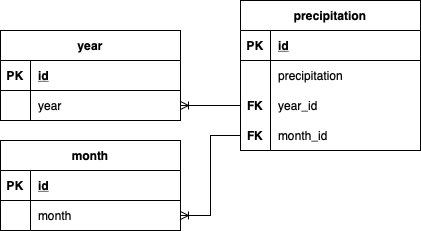

In [2]:
Image(filename='1.png')

In [11]:
try:
    connection = psycopg2.connect(host="localhost", 
                                  port = 5432,
                                  user="postgres",
                                  database='mydb',
                                  password="postgres")
except:
    print("I am unable to connect to the database")

In [12]:
cursor = connection.cursor()

In [13]:
cursor.execute("DROP TABLE IF EXISTS precipitation")
connection.commit()

In [14]:
cursor.execute("DROP TABLE IF EXISTS year")

cursor.execute("""CREATE TABLE year
                (id INT PRIMARY KEY, 
                 year INT)""")
connection.commit()

In [15]:
sql = "INSERT INTO year (id, year) VALUES (%s,%s)"

#tuple and than list
df3['year_id'] = df3[['id', 'year']].apply(tuple, axis=1)
year = list(df3['year_id'])

cursor.executemany(sql, year)
connection.commit()
print(cursor.rowcount, "record inserted")

235 record inserted


In [16]:
cursor.execute("DROP TABLE IF EXISTS month")

cursor.execute("""CREATE TABLE month
                (id INT PRIMARY KEY, 
                 month VARCHAR(255))""")
connection.commit()

In [17]:
sql = "INSERT INTO month (id, month) VALUES (%s,%s)"

month = [(1,'January'),(2,'February'),(3,'March'),(4,'April'),(5,'May'),(6,'June'),(7,'July'),(8,'August')
        ,(9,'September'),(10,'October'),(11,'November'),(12,'December')]

cursor.executemany(sql, month)
connection.commit()
print(cursor.rowcount, "record inserted")

12 record inserted


In [18]:
cursor.execute("DROP TABLE IF EXISTS precipitation")

cursor.execute("""CREATE TABLE precipitation
                (id INT PRIMARY KEY, 
                 precipitation INT,
                 year_id INT REFERENCES year(id),
                 month_id INT REFERENCES month(id))""")
connection.commit()

In [19]:
sql = "INSERT INTO precipitation (id, precipitation, year_id, month_id) VALUES (%s,%s,%s,%s)"

#tuple and than list
df_final['pecip'] = df_final[['precip_id','precip','year_id','month_id']].apply(tuple, axis=1)
values = list(df_final['pecip'])

cursor.executemany(sql, values)
connection.commit()
print(cursor.rowcount, "record inserted")

2820 record inserted


In [20]:
cursor.close()

## 3. Get dataset from database

In [288]:
try:
    connection = psycopg2.connect(host="localhost", 
                                  port = 5432,
                                  user="postgres",
                                  database='mydb',
                                  password="postgres")
except:
    print("I am unable to connect to the database")

In [289]:
cursor = connection.cursor()

In [290]:
try:
    query = """SELECT precipitation.precipitation, year.year, precipitation.month_id 
    FROM precipitation
    FULL OUTER JOIN year ON precipitation.year_id = year.id;"""
    df = pd.read_sql(query,connection)
except Exception as e:
    cursor.close()
    print(str(e))

In [291]:
df.rename(columns={"month_id": "month"},inplace=True)
df.head()

,precipitation,year,month
0,33,1786,1
1,28,1786,2
2,84,1786,3
3,42,1786,4
4,9,1786,5


## 4. Exploratory analysis

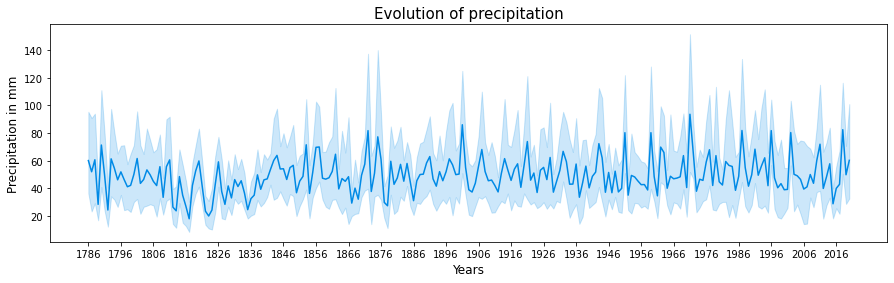

In [25]:
plt.figure(figsize =(15, 4))
sns.lineplot(x=df['year'],y=df['precipitation'], color='#008ae6')
x = df['year'].unique()
plt.xticks(np.arange(1786, max(x), 10))

plt.title("Evolution of precipitation",fontsize=15)
plt.xlabel("Years",fontsize=12)
plt.ylabel("Precipitation in mm",fontsize=12)
plt.show()

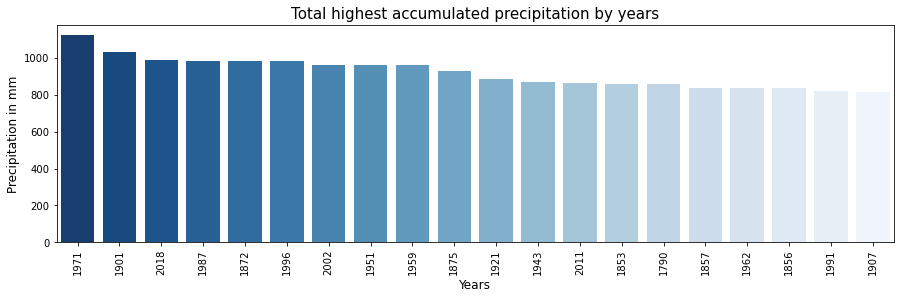

In [26]:
#years with the most accumulated precipitation
high_rain = df.groupby(['year']).sum()
high_rain = high_rain.sort_values(['precipitation'],ascending=False)
high_rain['year'] = high_rain.index
high_rain.reset_index(drop=True, inplace=True)
high_rain = high_rain.head(20)

plt.figure(figsize =(15, 4))
sns.barplot(x="year", y="precipitation", data=high_rain,order=high_rain['year'], palette="Blues_r")
    
plt.title("Total highest accumulated precipitation by years",fontsize=15)
plt.xlabel("Years",fontsize=12)
plt.ylabel("Precipitation in mm",fontsize=12)
plt.xticks(rotation=90)
plt.show()

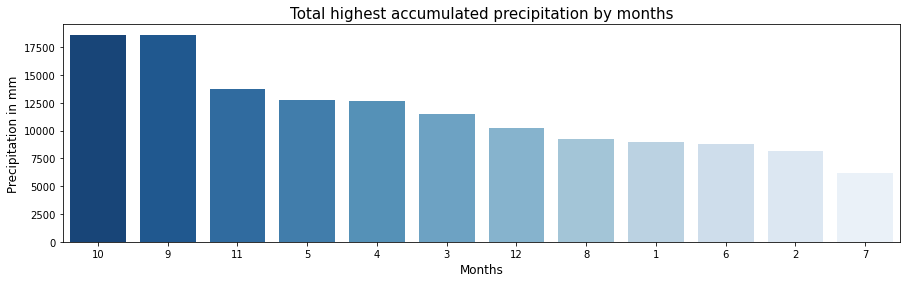

In [293]:
#months with the most accumulated precipitation
high_rain = df.groupby(['month']).sum()
high_rain = high_rain.sort_values(['precipitation'],ascending=False)
high_rain['year'] = high_rain.index
high_rain.reset_index(drop=True, inplace=True)
high_rain = high_rain.head(20)

plt.figure(figsize =(15, 4))
sns.barplot(x="year", y="precipitation", data=high_rain,order=high_rain['year'], palette="Blues_r")
    
plt.title("Total highest accumulated precipitation by months",fontsize=15)
plt.xlabel("Months",fontsize=12)
plt.ylabel("Precipitation in mm",fontsize=12)
plt.show()

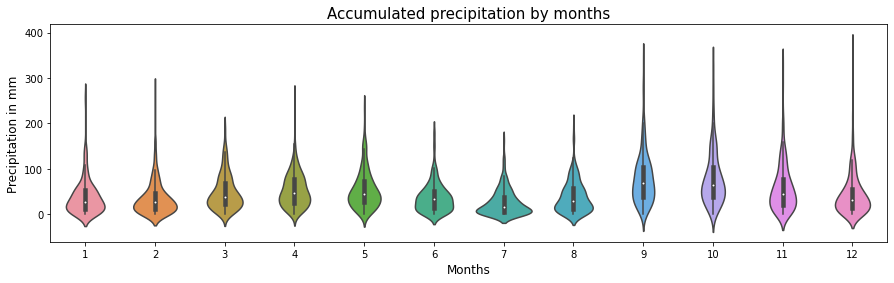

In [27]:
#distribution of precipitation
plt.figure(figsize =(15, 4))

#violinplot
sns.violinplot(x="month", y="precipitation", data=df)
plt.title("Accumulated precipitation by months",fontsize=15)
plt.xlabel("Months",fontsize=12)
plt.ylabel("Precipitation in mm",fontsize=12)
plt.show()

Median in each month is represented by white dot, black bar in the center represents interquartile range and the black lines stretched from the bar are lower and upper adjacent values. These values can be used for outlier detection. The violin plot also shows the distribution of data in each month.

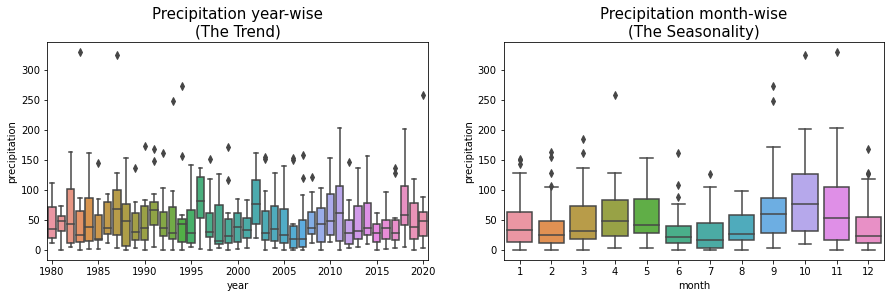

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

years = df[df['year']>=1980]
x = years['year'].unique()

sns.boxplot(x='year', y='precipitation', data=years, ax=axes[0])
sns.boxplot(x='month', y='precipitation', data=years, ax=axes[1])

axes[0].set_title('Precipitation year-wise\n(The Trend)', fontsize=15)
axes[0].set_xticks(np.arange(0, len(x)+1, 5))
axes[1].set_title('Precipitation month-wise\n(The Seasonality)', fontsize=15)
plt.show()

## 5. Time series

### Type of series
Data about accumulated precipitation contains a sequence of data points in time, for that reason time-series forecasting should be applied. Trend, Seasonality, irregularity and cyclic character is studied to choose the right model for prediction.

### Stationarity
Statistical modeling methods assume or require the time series to be stationary to be effective. Stationarity means that the statistical properties of the process do not change over time - constant mean and variance.

For a forecasting model only values from past 40 years have been considered to simplify the model.

In [505]:
#precipitation of last 10 years
df_study = df.tail(120)

In [506]:
df_study.head()

,precipitation
2700,42
2701,24
2702,185
2703,18
2704,89


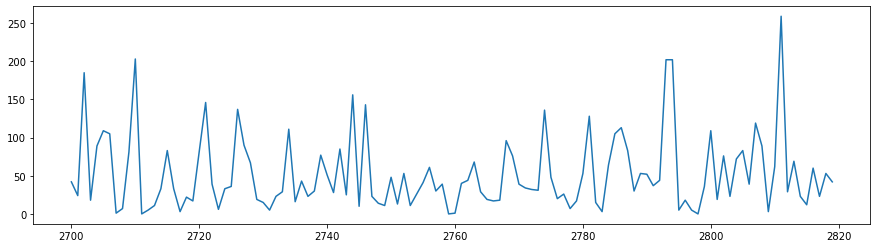

In [507]:
#visual check
df_study['precipitation'].plot(figsize=(15, 4))
plt.show()

In [508]:
#summary statistics
series = df_study['precipitation']
X = series.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=49.433333, mean2=55.166667
variance1=2281.412222, variance2=2609.638889


Summary statistics method suggest dividing the dataset in two parts and observing the values of mean and variance. The results are different in both parts but to claim dataset stationary or not is necessary to perform statistical test.

- $H_0: \mu_A = $ Time series has a unit root, it is non-stationary and has some dependent structure.
- $H_1: \mu_A = $ Time series is stationary.

In [509]:
#statistics
results = adfuller(df_study.precipitation.values)
print(f'ADF Statistic: {results[0]}')
print(f'P-value: {results[1]}')
for key, value in results[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -10.173728591705999
P-value: 6.980292875496629e-18
Critial Values:
   1%, -3.4865346059036564
Critial Values:
   5%, -2.8861509858476264
Critial Values:
   10%, -2.579896092790057


Running the test prints the ADF statistic value of -10.17. The more negative this statistic is, more likely we are to reject the null hypothesis (we have a stationary dataset). ADF statistic value is also less than 1% critical values.

This test suggests we can reject the null hypothesis with a significance level of less than 1%. Time series is stationary.

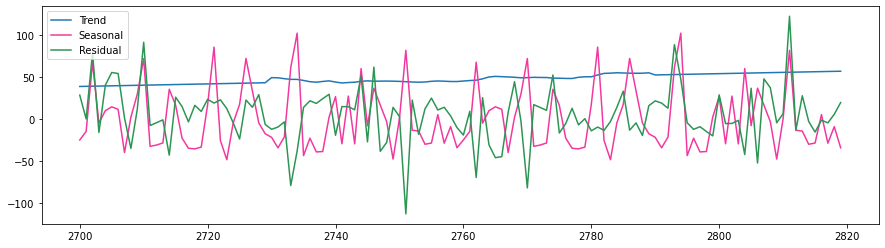

In [510]:
decomposition = seasonal_decompose(df_study['precipitation'],model='additive', extrapolate_trend='freq',period = int(len(df_study)/2) )

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize =(15, 4))
plt.plot(trend,label = 'Trend')
plt.plot(seasonal,label = 'Seasonal', color="#F2389E")
plt.plot(residual,label = 'Residual', color="#2B9553")
plt.legend(loc="upper left")
plt.show()

### Autocorrelation or partial autocorrelation

Autocorrelation the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value. Partial Autocorrelation also shows the pure correlation of a series and its lag, seeks to remove indirect correlations and describes the direct relationship between and observation and its lag. 

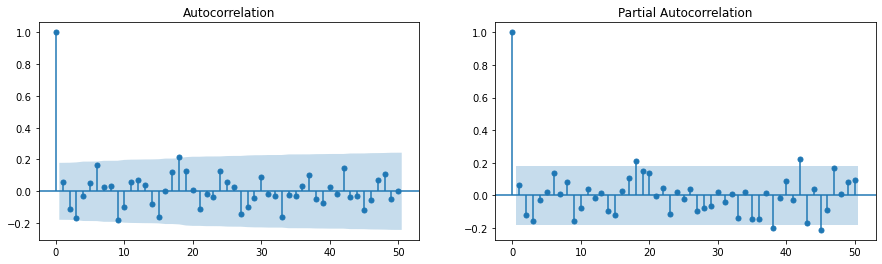

In [511]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
a = plot_acf(df_study.precipitation.tolist(), lags=50, ax=axes[0])
b = plot_pacf(df_study.precipitation.tolist(), lags=50, ax=axes[1])
plt.show(a)
plt.show(b)

Both graphs have a sharp cut-off, that means it might be difficult to create a forecast model.

From Autocorrelation graph we can observe the values drops after first lag. ACF suggests fitting first - order in moving average term.

On the graph the partial autocorrelation for lags 1 is statistically significant.The subsequent lags decline to rather non-significant levels. Consequently, this PACF suggests fitting first - order autoregressive model.

### Arima

An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

Paremeters:
- p: AR term can be find out inspecting the PACF plot. We can see sharp cut-off at lag-1, that suggest p=1. Lag-2 turns out to be significant as well but is very close to the significance limit(blue region).
- q: MA term can be find out inspecting the ACF plot. Fist two lags are laying above the significance line, but only the first one has sharp cut-off. In order to obtain simplier model q=1.
- d: I term is the number of times that the raw observations are differenced, also called the degree of differencing. Time series is staionary and that's why d=0.

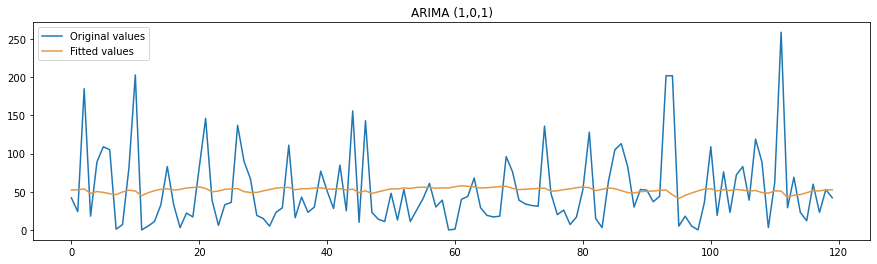

In [543]:
data = df_study.precipitation.tolist()
model = sm.tsa.arima.ARIMA(data, order =(1,0,1))
model_fit = model.fit()

plt.figure(figsize =(15, 4))
plt.plot(data,label = 'Original values')
plt.plot(model_fit.fittedvalues, color='#E39844',label = 'Fitted values')
plt.title('ARIMA (1,0,1)')
plt.legend(loc="upper left")
plt.show()

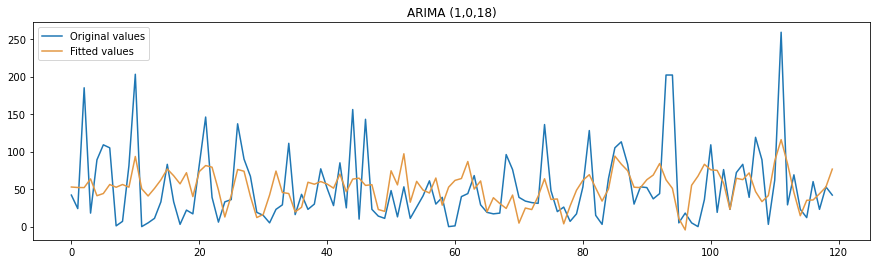

In [564]:
data = df_study.precipitation.tolist()
model = sm.tsa.arima.ARIMA(data, order =(1,0,18))
model_fit = model.fit()

plt.figure(figsize =(15, 4))
plt.plot(data,label = 'Original values')
plt.plot(model_fit.fittedvalues, color='#E39844',label = 'Fitted values')
plt.title('ARIMA (1,0,18)')
plt.legend(loc="upper left")
plt.show()

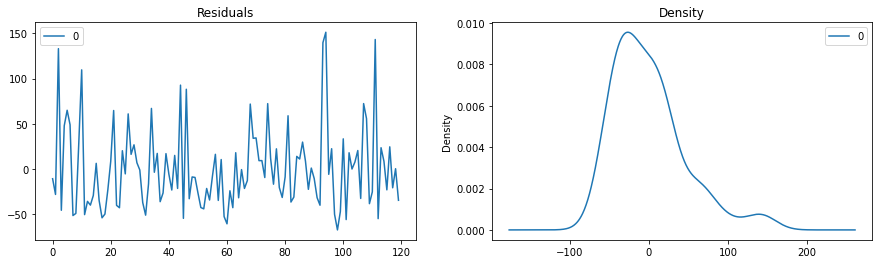

In [565]:
#plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2,figsize =(15, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [566]:
print(residuals.describe())

                0
count  120.000000
mean     0.006496
std     45.523372
min    -67.341661
25%    -34.365139
50%     -8.774433
75%     18.533061
max    151.130785


The residual errors seem fine with near zero mean and uniform variance.

In [567]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  120
Model:                ARIMA(1, 0, 18)   Log Likelihood                -627.341
Date:                Fri, 14 Jan 2022   AIC                           1296.681
Time:                        17:54:43   BIC                           1355.219
Sample:                             0   HQIC                          1320.454
                                - 120                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.7533      9.603      5.494      0.000      33.933      71.574
ar.L1         -0.0140      0.717     -0.020      0.984      -1.420       1.392
ma.L1         -0.0330      0.829     -0.040      0.9

In [568]:
df_study['precipitation'].mean()

52.3

In [569]:
MAE = mean_absolute_error(data, model_fit.fittedvalues)
print('MAE: %f' % MAE)

MAE: 34.869258


Mean Absolute Error shows us how much inaccuracy we should expect from the forecast on average.

In [570]:
MSE = mean_squared_error(data, model_fit.fittedvalues)
print('MSE: %f' % MSE)

MSE: 2055.107607


Mean Squared Error is calculated as the average of the squared forecast error values. Result is very high and indicates error in forecasting.

In [571]:
RMSE = np.sqrt(MSE)
print('RMSE: %f' % RMSE)

RMSE: 45.333295


In [572]:
fitted_values = model_fit.fittedvalues
forecast_errors = [data[i]-fitted_values[i] for i in range(len(fitted_values))]
print('Forecast Errors: %s' % forecast_errors)

Forecast Errors: [-10.753299057299188, -28.131717544466227, 132.9992000289005, -45.630894964151054, 47.83642380079324, 64.89761680287967, 48.88910618110373, -51.43606686340496, -49.10076834070673, 28.428716882043275, 109.55942984128012, -50.43748255762543, -35.81412891956563, -39.914342874170025, -29.265977637702008, 6.232073337420999, -34.78272380223585, -53.96751579880273, -49.82326422479687, -23.020937728219913, 8.664522127740412, 64.62517380123792, -40.210385525310954, -42.81788300758093, 20.186862217617296, -5.407811878378233, 60.88370915464178, 16.193259743590048, 26.699131416508727, 6.929602373551738, -1.1290818306016135, -37.09304277448469, -51.02660551243693, -16.419085397057913, 66.93411262444661, -3.617937854428355, 17.20767348398343, -36.1268064380798, -26.493720565816304, 16.955225128438265, -5.728167180326572, -23.24091233235115, 14.989624378145635, -21.48270053418957, 92.68043368430531, -54.56398963931298, 88.12733556155737, -32.88315645154359, -8.798158696069972, -9.337

In [573]:
bias = sum(forecast_errors) * 1.0/len(fitted_values)
print('Bias: %f' % bias)

Bias: 0.006496


Units of the forecast bias are the same as the units of the predictions. A forecast bias of zero, or a very small number near zero, shows an unbiased model.

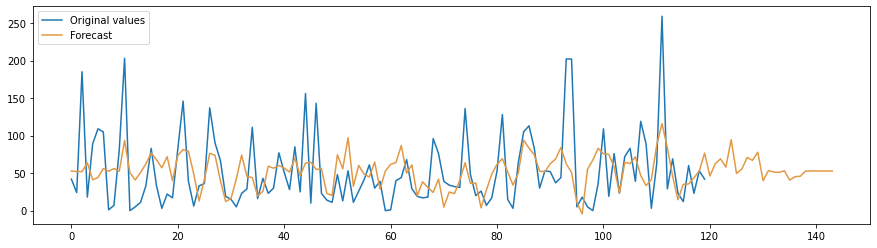

In [574]:
#forecast 2 years
forecasts = model_fit.forecast(steps=24, alpha = 0.05)

results = np.concatenate((fitted_values, forecasts))

plt.figure(figsize =(15, 4))
plt.plot(data, label='Original values')
plt.plot(results,label='Forecast',color='#E39844')
plt.legend(loc="upper left")
plt.show()

### Conclusions:
- The time series dataset is tough to make predictions, model is not having good accuracy and it is hard to distinguish data pattern to make a prediction.
- The model should be tuned in orther to improve performance by different ARIMA configuration or with more number of predictors (independent variables).

## 6. Supervised ML

In [35]:
df2 = pd.read_csv('TemperaturesBarcelonaDesDe1780.csv')
df2.drop(['Unnamed: 0'],axis=1, inplace=True)

In [36]:
df2.head(2)

,Any,Temp_Mitjana_Gener,Temp_Mitjana_Febrer,Temp_Mitjana_Marc,Temp_Mitjana_Abril,Temp_Mitjana_Maig,Temp_Mitjana_Juny,Temp_Mitjana_Juliol,Temp_Mitjana_Agost,Temp_Mitjana_Setembre,Temp_Mitjana_Octubre,Temp_Mitjana_Novembre,Temp_Mitjana_Desembre
0,1780,6.7,7.3,11.6,11.4,16.3,19.1,21.4,22.0,20.3,16.3,9.2,7.3
1,1781,7.5,8.9,10.9,13.7,16.8,18.0,22.0,22.6,19.1,15.0,11.8,10.3


In [37]:
#check if the length
print(len(df2))

241


In [38]:
#rename columns to english
df2.rename(columns={"Any": "year",
                   'Temp_Mitjana_Gener': 1,
                   'Temp_Mitjana_Febrer': 2,
                   'Temp_Mitjana_Marc': 3,
                   'Temp_Mitjana_Abril': 4,
                   'Temp_Mitjana_Maig': 5,
                   'Temp_Mitjana_Juny': 6,
                   'Temp_Mitjana_Juliol': 7,
                   'Temp_Mitjana_Agost': 8,
                   'Temp_Mitjana_Setembre': 9,
                   'Temp_Mitjana_Octubre': 10,
                   'Temp_Mitjana_Novembre': 11,
                   'Temp_Mitjana_Desembre': 12},inplace=True)
df2.head(2)

,year,1,2,3,4,5,6,7,8,9,10,11,12
0,1780,6.7,7.3,11.6,11.4,16.3,19.1,21.4,22.0,20.3,16.3,9.2,7.3
1,1781,7.5,8.9,10.9,13.7,16.8,18.0,22.0,22.6,19.1,15.0,11.8,10.3


In [39]:
df2 = df2[df2['year'] >= 1786]
len(df2)

235

In [40]:
#reorganize dataset precipitations
df2 = df2.melt(id_vars=["year"],var_name="month")
df2.rename(columns={"value": "temp"},inplace=True)
df2.sort_values(by=["year", "month"],inplace=True)
df2 = df2.reset_index(drop=True)

In [41]:
df2.head(2)

,year,month,temp
0,1786,1,7.8
1,1786,2,8.3


In [42]:
df1['temp'] = df2['temp']
df1.head(2)

,year,month,precip,temp
0,1786,1,32.8,7.8
1,1786,2,28.4,8.3


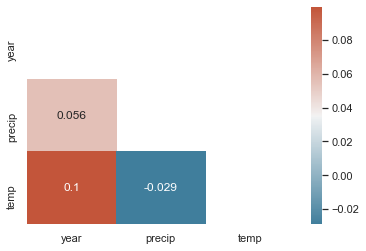

In [47]:
#Correlation matrix
fig,ax = plt.subplots(figsize=(6,4))
corr = df1.corr()
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap)
plt.show()

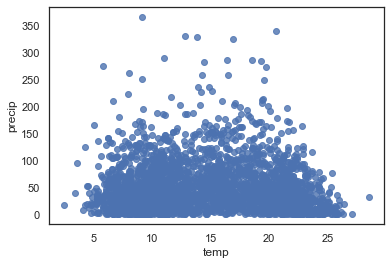

In [106]:
#Relationship between temp and precip
fig,ax = plt.subplots(figsize=(6,4))
sns.regplot(x="temp", y="precip", data=df1, fit_reg=False)
plt.show()

In [177]:
df1.describe()

,year,precip,temp
count,2820.000000,2820.000000,2820.000000
mean,1903.000000,49.414504,14.570674
std,67.850074,45.308732,5.519488
min,1786.000000,0.000000,2.500000
25%,1844.000000,16.775000,9.700000
50%,1903.000000,37.550000,14.000000
75%,1962.000000,69.100000,19.600000
max,2020.000000,365.800000,28.500000


In [178]:
df1.isna().sum()

year      0
month     0
precip    0
temp      0
dtype: int64

In [179]:
df1 = df1.astype(float)

In [216]:
target = df1['precip']

In [181]:
scaler = StandardScaler()
df_mod = scaler.fit_transform(X)
df_scaled = pd.DataFrame(df_mod, index=X.index, columns=X.columns)
df_scaled.head(3)

,year,month,temp
0,-1.724696,-1.593255,-1.226903
1,-1.724696,-1.303572,-1.136298
2,-1.724696,-1.013890,-0.846365


In [225]:
#divide test and train based on historical order
#train model with values from the past and than observe the predicted values in last 70 years
X_train = df_scaled[:1980]
X_test = df_scaled[1980:]
y_train = target[:1980]
y_test = target[1980:]
print(len(X_train), len(X_test),len(y_train),len(y_test))

1980 840 1980 840


In [220]:
#RandomForestRegressor model
model1 = RandomForestRegressor(n_estimators = 100, random_state = 42)
model1.fit(X_train, y_train)
score1 = model1.score(X_train,y_train)
y_pred1 = model1.predict(X_test)
print(score1)

0.8592272822585488


In [221]:
#importancy of the features
pd.Series(model1.feature_importances_, index=X_train.columns)

year     0.474686
month    0.157150
temp     0.368163
dtype: float64

In [222]:
#Stratified k-Fold validation
skf = KFold(n_splits=10,shuffle=True, random_state=1)
model1_accu_stratified = []

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    model1.fit(x_train_fold, y_train_fold)
    model1_accu_stratified.append(model1.score(x_test_fold, y_test_fold))

print('List of possible accuracy:', model1_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is:', max(model1_accu_stratified)*100, '%')
print('Minimum Accuracy:', min(model1_accu_stratified)*100, '%')
print('Overall Accuracy:', statistics.mean(model1_accu_stratified)*100, '%')
print('Standard Deviation is:', statistics.stdev(model1_accu_stratified))

List of possible accuracy: [-0.21275768399013217, 0.06440685186196438, -0.02160732477015692, -0.018637087345665826, 0.024084997641528383, -0.02234228904775426, -0.1840607682885842, 0.09625748162584458, 0.042769114761213034, -0.04490944946435582]
Maximum Accuracy That can be obtained from this model is: 9.625748162584458 %
Minimum Accuracy: -21.275768399013216 %
Overall Accuracy: -2.7679615701609883 %
Standard Deviation is: 0.10035263985347302


In [223]:
R2_1 = round(r2_score(y_test,y_pred1),4)
MSE1 = round(mean_squared_error(y_test,y_pred1),4)
MAE1 = round(mean_absolute_error(y_test,y_pred1),4)
RMSE1 = round(np.sqrt(MSE1),4)

print('R2 score is:', R2_1)
print('Mean square error is:',MSE1)
print('Mean absolute error is:',MAE1)
print('Root mean square error is:',RMSE1)

R2 score is: -0.04
Mean square error is: 2563.696
Mean absolute error is: 35.323
Root mean square error is: 50.633


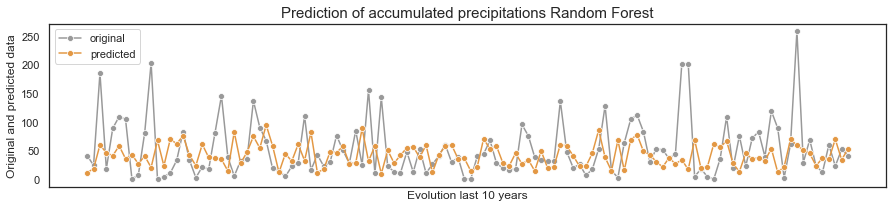

In [232]:
#compare values from test and predict model
y1 = y_test.reset_index(drop=True)
y2 = pd.Series(y_pred1)

simple_df1 = y1[720:len(y1)]
simple_df2 = y2[720:len(y2)]

plt.figure(figsize =(15, 3))

sns.lineplot(data=simple_df1, color='#999999',label='original', marker='o')
sns.lineplot(data=simple_df2, color='#E39844',label='predicted', marker='o')
plt.title("Prediction of accumulated precipitations Random Forest",fontsize=15)
plt.xlabel("Evolution last 10 years",fontsize=12)
plt.ylabel("Original and predicted data",fontsize=12)
plt.xticks([])
plt.show()

In [233]:
#XBoost model
model2 = XGBRegressor()
model2.fit(X_train, y_train)
score2 = model2.score(X_train,y_train)
y_pred2 = model2.predict(X_test)
print(score2)

0.8890541055543081


In [234]:
#Stratified k-Fold validation
skf = KFold(n_splits=10,shuffle=True, random_state=1)
model2_accu_stratified = []

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    model2.fit(x_train_fold, y_train_fold)
    model2_accu_stratified.append(model2.score(x_test_fold, y_test_fold))

print('List of possible accuracy:', model2_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is:', max(model2_accu_stratified)*100, '%')
print('Minimum Accuracy:', min(model2_accu_stratified)*100, '%')
print('Overall Accuracy:', statistics.mean(model2_accu_stratified)*100, '%')
print('Standard Deviation is:', statistics.stdev(model2_accu_stratified))

List of possible accuracy: [-0.29912716108228765, -0.04875070467533349, -0.062261093923942745, -0.04572040784655429, -0.0012284518404070965, -0.017861502591809852, -0.1800546270299932, 0.10249969169001483, 0.018930022858521967, -0.15263069380608196]
Maximum Accuracy That can be obtained from this model is: 10.249969169001483 %
Minimum Accuracy: -29.912716108228764 %
Overall Accuracy: -6.862049282478735 %
Standard Deviation is: 0.11432587011402218


In [235]:
R2_2 = round(r2_score(y_test,y_pred2),4)
MSE2 = round(mean_squared_error(y_test,y_pred2),4)
MAE2 = round(mean_absolute_error(y_test,y_pred2),4)
RMSE2 = round(np.sqrt(MSE2),4)

print('R2 score is:', R2_2)
print('Mean square error is:',MSE2)
print('Mean absolute error is:',MAE2)
print('Root mean square error is:',RMSE2)

R2 score is: -0.1191
Mean square error is: 2758.6894
Mean absolute error is: 36.4077
Root mean square error is: 52.5232


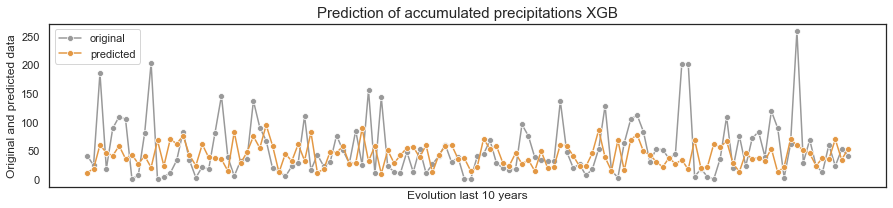

In [236]:
#compare values from test and predict model
y1 = y_test.reset_index(drop=True)
y2 = pd.Series(y_pred1)

simple_df1 = y1[720:len(y1)]
simple_df2 = y2[720:len(y2)]

plt.figure(figsize =(15, 3))

sns.lineplot(data=simple_df1, color='#999999',label='original', marker='o')
sns.lineplot(data=simple_df2, color='#E39844',label='predicted', marker='o')
plt.title("Prediction of accumulated precipitations XGB",fontsize=15)
plt.xlabel("Evolution last 10 years",fontsize=12)
plt.ylabel("Original and predicted data",fontsize=12)
plt.xticks([])
plt.show()

### Conclusions:
- Very high RMSE value points out that the both models perform badly.
- Temperature and precipitation values are not correlated, one of the reasons why added values of temperature did not helped significantly to build a good prediction model.
- More data is necessary to add to dataset in order to obtain a good model to predict precipitations. For exemple: wind data, moisture levels, atmosferic pressure, CO2 levels.

## 7. Unsupervised ML

In [281]:
df.head(3)

,precipitation,year,month
0,33,1786,1
1,28,1786,2
2,84,1786,3


In [282]:
scaler = StandardScaler()
df_mod = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_mod, index=df.index, columns=df.columns)
df_scaled.head(3)

,precipitation,year,month
0,-0.363288,-1.724696,-1.593255
1,-0.473648,-1.724696,-1.303572
2,0.762385,-1.724696,-1.013890


In [283]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_scaled)
df_final = pd.DataFrame(data = pca_data, columns = ['component1', 'component2'])
df_final.head(3)

,component1,component2
0,-1.742573,-1.048090
1,-1.629068,-1.150756
2,-0.563520,-1.253421


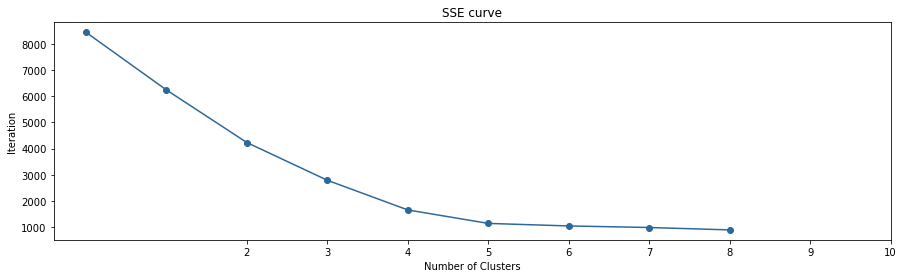

In [284]:
plt.figure(figsize=(15, 4)) 
plt.plot(sse, marker= "o",color='#2D689C')
plt.xticks(range(2, 11))
plt.title("SSE curve")
plt.xlabel("Number of Clusters")
plt.ylabel("Iteration")
plt.show()

From above graph is not so evident which would be the best k number of clustres.

In [287]:
#how many clusters? elbow method
sse = []
for k in range(2, 11):
    model = KMeans(n_clusters=k, max_iter= 300, random_state = 42)
    model.fit(df_final)
    sse.append(model.inertia_)
kl = KneeLocator(range(2, 11), sse, curve="convex", direction="decreasing")
print('Ideal cluster number is:', kl.elbow)

Ideal cluster number is: 4


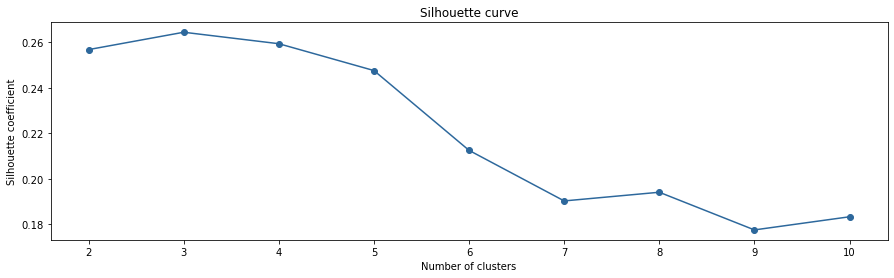

In [286]:
#silhouette curve
silhouette_coefficients = []
for k in range(2, 11):
    model = KMeans(n_clusters=k)
    model.fit(df_final)
    score1 = silhouette_score(df_scaled, model.labels_)
    silhouette_coefficients.append(score1)
    
plt.figure(figsize =(15, 4))
plt.plot(range(2, 11), silhouette_coefficients, marker= "o",color='#2D689C')
plt.xticks(range(2, 11))
plt.title("Silhouette curve")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.show()

Silhouette coeficient improves significantly at k number 7. For that reason the number of clusters would be 7 and not 4 because it will improve the performance.

In [262]:
model = KMeans(init="random",n_clusters=7,n_init=10,max_iter=300,random_state=42)
model.fit(df_final)

KMeans(init='random', n_clusters=7, random_state=42)

In [263]:
y_kmeans = model.predict(df_final)
df_final['cluster'] = y_kmeans
df_final.head()

,component1,component2,cluster
0,-1.742573,1.048090,4
1,-1.629068,1.150756,4
2,-0.563520,1.253421,4
3,-1.027484,1.356086,4
4,-1.350983,1.458751,4


In [264]:
#score
labels = model.labels_
silhouette1 = metrics.silhouette_score(df_final, labels, metric = 'euclidean')
print('Silhouette score is:',round(silhouette1,2))

Silhouette score is: 0.63


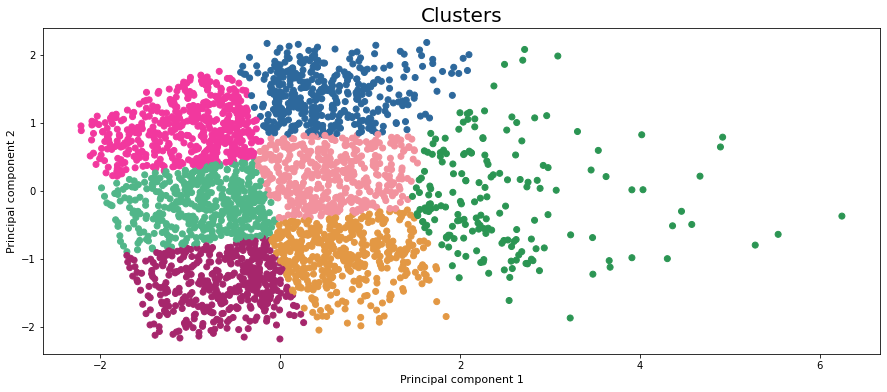

In [275]:
plt.figure(figsize=(15, 6))
fte_colors = {0: "#51B689",1: "#2D689C",2: "#E39844", 3: "#F2929E",
              4: "#F2389E",5: "#A6266C",6: "#2B9553"}
km_colors = [fte_colors[label] for label in model.labels_]

plt.scatter(df_final['component1'], df_final['component2'], c=km_colors)

plt.title("Clusters", fontsize = 20)
plt.xlabel("Principal component 1",fontsize = 11)
plt.ylabel("Principal component 2",fontsize = 11)
plt.show()

In [266]:
conditions = [(df_final['cluster'] == 0),
              (df_final['cluster'] == 1),
              (df_final['cluster'] == 2),
              (df_final['cluster'] == 3),
              (df_final['cluster'] == 4),
              (df_final['cluster'] == 5),
              (df_final['cluster'] == 6)]

values = [1, 2, 3, 4, 5, 6, 7]
df_final['cluster'] = np.select(conditions, values)

In [267]:
df_clusters = df.copy()
df_clusters['cluster'] = df_final['cluster']
df_clusters.head(3)

,precipitation,year,month,cluster
0,33,1786,1,5
1,28,1786,2,5
2,84,1786,3,5


In [ ]:
#save
df_clusters.to_csv('df_clusters.csv')

In [241]:
df_clusters = pd.read_csv('df_clusters.csv')
df_clusters.drop(['Unnamed: 0'],axis=1, inplace=True)

In [242]:
df_clusters['cluster'].value_counts()

5    499
1    460
3    438
6    425
4    424
2    391
7    183
Name: cluster, dtype: int64

In [243]:
df_clusters.groupby(['cluster']).mean()

,precipitation,year,month
cluster,,,
1,28.847826,1898.065217,3.904348
2,57.452685,1826.485934,9.941176
3,61.710046,1979.474886,7.614155
4,55.912736,1903.247642,8.794811
5,25.370741,1823.184369,4.605210
6,27.818824,1979.058824,3.461176
7,155.857923,1936.273224,9.912568


In [244]:
cluster7 = df_clusters[df_clusters['cluster'] == 7]
cluster7['month'].mode()

0    10
dtype: int64

In [245]:
cluster5 = df_clusters[df_clusters['cluster'] == 5]
cluster5['month'].mode()

0    7
dtype: int64

In [246]:
df_high = df_clusters[df_clusters['cluster'] == 7]
df_high.groupby(['cluster','year'])['precipitation'].sum().sort_values(ascending=False)

cluster  year
7        1971    747
         1901    665
         1943    572
         1987    529
         1872    502
                ... 
         1903     87
         1948     84
         2004     78
         1964     67
         1950     65
Name: precipitation, Length: 126, dtype: int64

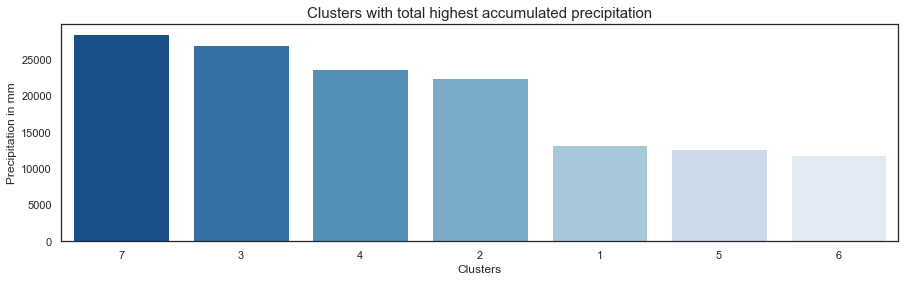

In [250]:
#clusters with the most accumulated precipitation
df_cl = df_clusters.groupby(['cluster']).sum()
df_cl = df_cl.sort_values(['precipitation'],ascending=False)
df_cl['year'] = df_cl.index
df_cl.reset_index(drop=True, inplace=True)

plt.figure(figsize =(15, 4))
sns.barplot(x="year", y="precipitation", data=df_cl, order=df_cl['year'], palette="Blues_r")
    
plt.title("Clusters with total highest accumulated precipitation",fontsize=15)
plt.xlabel("Clusters",fontsize=12)
plt.ylabel("Precipitation in mm",fontsize=12)
plt.show()

### Conclusions:
- All clusters has very similar amout of datapoints
- Cluster 7 contains the highest values of precipitation in autumn months, mostly October. On the visualization diagram corresponds to the dark green values which can be seen as outliers.
- Cluster 5 contains the lowest values of precipitation in autumn months, mostly July.
- The year of highest accumulated precipitations in autumn months is 1971.
- Clusters 1, 2 and 5 contains values older periods of time, mostly 19th centuary. These clusters lower average of precipitation values. 
- Cluster 7 and cluster 2 both contain values from autumn months. The big difference is in the average precipitation, in the 19th centuary is much more lower that in the recent years of cluster 7.